In [745]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.optimize import root


kcant =  10
l0 = 200
xi = 0.5
tr = 0.2
lp = 50
K = 1100
L = 300
kT = 4.1
mu = 2./kT
etaH2O = 0.89
aeff = 25000
heff = 5000
tf = 2.
dt = 10**-4
steps = int(tf/dt)
dU0 = 25
yB = 1.
ycusp = yB/2
dU = 16*dU0/yB**4.
beta = 1/4.1
k0, d = .1*10**-3, .4

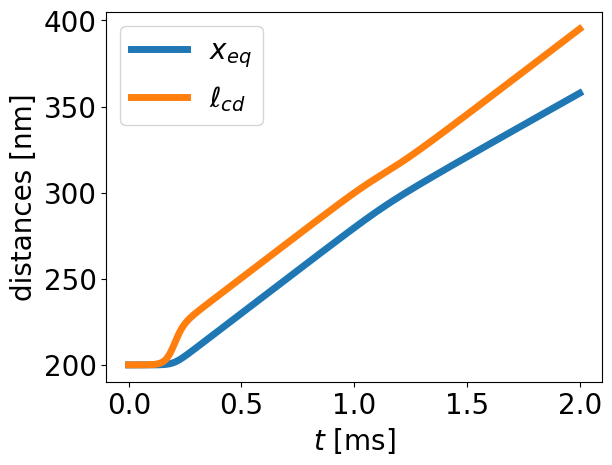

In [774]:
xeq = np.genfromtxt('xeq.csv', delimiter=',')
lamcd = np.genfromtxt('lamcdtab.csv', delimiter=',')
plt.plot(np.linspace(0., tf, len(xeq)), xeq, label=r'$x_{eq}$', linewidth=5)

# Plot the second line (lamcd)
plt.plot(np.linspace(0., tf, len(lamcd)), lamcd, label=r'$\ell_{cd}$', linewidth=5)

# Add labels and title
plt.xlabel(r'$t$ [ms]', fontsize=20)
plt.ylabel('distances [nm]', fontsize=20)
# plt.title('Plot of $x_{eq}$ and $\ell_{cd}$', fontsize=20)
custom_ticks = np.arange(0.0, 2.1, 0.5)
custom_ticksy = np.arange(200,410, 50)
plt.xticks(custom_ticks)
# Set the font size of ticks
plt.yticks(custom_ticksy)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Show legend with fontsize 15
plt.legend(fontsize=20)

# Show plot
plt.show()

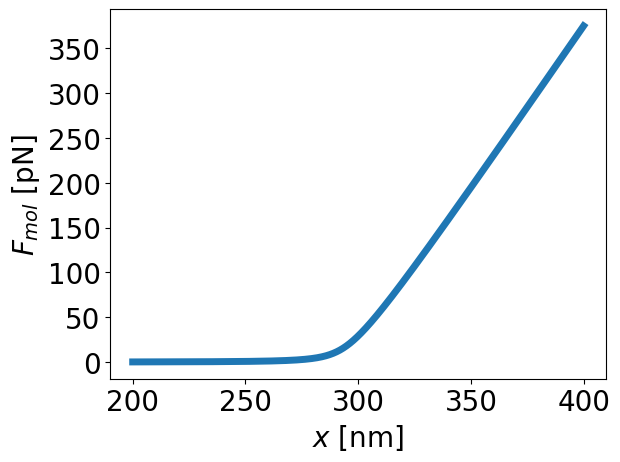

In [801]:
xtab = np.linspace(200,400,10000)
Fmol = []
Fmol0 = 0.
for i in range(len(xtab)):
    x = xtab[i]
    def func(Fx):
        return Fx - kT/lp*(.25/(1-x/L+Fx/K)**2.-.25+x/L-Fx/K)
    if i == 0:
        sol = root(func, Fmol0)
    else:
        sol = root(func, Fmol[-1])
    Fmol.append(sol.x[0])
    

plt.plot(xtab, Fmol, label=r'$F_eq$', linewidth=5)

# Plot the second line (lamcd)
# plt.plot(np.linspace(0., tf, len(lamcd)), lamcd, label=r'$\ell_{cd}$', linewidth=5)

# Add labels and title
plt.xlabel(r'$x$ [nm]', fontsize=20)
plt.ylabel(r'$F_{mol}$ [pN]', fontsize=20)
# plt.title('Plot of $x_{eq}$ and $\ell_{cd}$', fontsize=20)
custom_ticks = np.arange(200,410, 50)
custom_ticksy = np.arange(0,400, 50)
plt.xticks(custom_ticks)
# Set the font size of ticks
plt.yticks(custom_ticksy)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
# Show legend with fontsize 15
# plt.legend(fontsize=15)


    

In [720]:
xeq

array([0., 0., 0., ..., 0., 0., 0.])

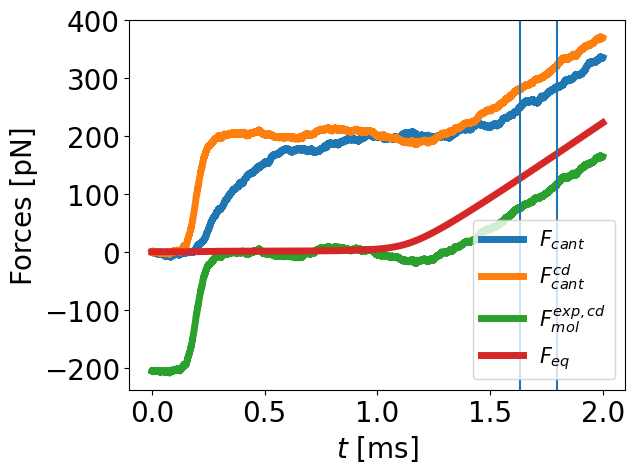

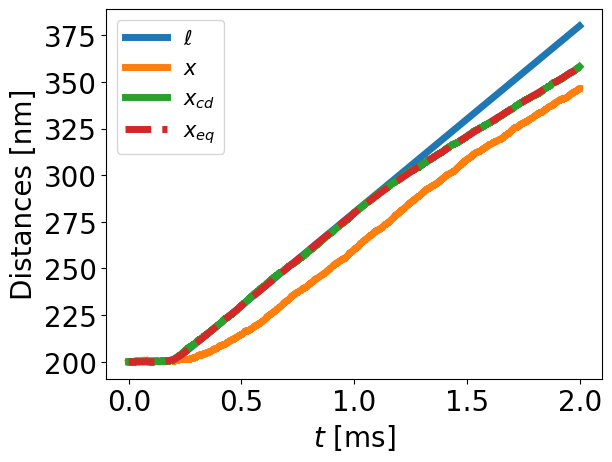

Regular pulling
CD pulling
217.29797942876527 1.4278991420242502
248.83997636045723 1.3599850483463487


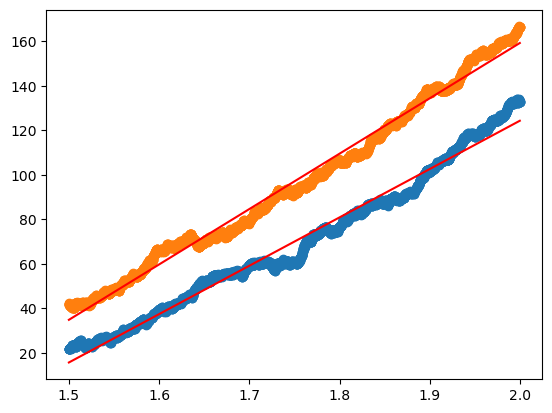

In [804]:
from numba import jit
@jit(nopython=True)
def linear_interpolation(x1, y1, x2, y2, x_interpolate):

    # Calculate the slope of the line passing through the two points
    slope = (y2 - y1) / (x2 - x1)
    
    # Calculate the y-intercept of the line
    intercept = y1 - slope * x1
    
    # Calculate the interpolated y value using the equation of the line
    y_interpolate = slope * x_interpolate + intercept
    
    return y_interpolate



@jit(nopython=True)
def traj(v,Fmoltab,xtab, seed):
    dx = xtab[1]-xtab[0]
    np.random.seed(seed)
#     print('seed = ', seed)
    x,t = 200,0.
    kM = 100.
    y = 0
    trup = 0.
    D0 = 1960 #nm^2/s
    D00 = .392 #(nm/s)
    trig = False
    dt = .0001
    xt, Fcantt, l, xeq, Fexpmol, Dx = np.zeros(steps),np.zeros(steps),np.zeros(steps),np.zeros(steps),np.zeros(steps),np.zeros(steps)
    for i in range(steps):
        lt = l0 + np.log(1+np.exp(xi*(t-tr)*v))/xi
        Fcant = kcant*(lt-x)
        ind = int(np.floor((x-200)/dx))
#         print(ind, lt)
        x1, y1, x2, y2 = xtab[ind], Fmoltab[ind], xtab[ind+1], Fmoltab[ind+1]
        Fmol = linear_interpolation(x1, y1, x2, y2, x)
#         print(Fmol, dx, Fcant)
        Dxi = D0 + D00*x 
        Dxi = 2.
#         Dxi = 1.
        F = Fcant - Fmol
#         print(x, Fcant, lt, 0., kcant*(lt-x)-kT*v/Dxi, Dxi)
        xt[i], Fcantt[i], l[i], xeq[i], Fexpmol[i], Dx[i] = x, Fcant, lt, 0., kcant*(lt-x)-kT*v/Dxi, Dxi
        x = x + dt*F*mu + (2*2.*dt)**.5*np.random.randn()

        kF = k0*np.exp(beta*Fmol*d) 
        if dt*kF > np.random.rand() and trig == False:
            trig = True
            trup = t

        t += dt
     
        
    return np.asarray(xt), np.asarray(Fcantt), np.asarray(l),np.asarray(xeq), np.asarray(Fexpmol), trup


@jit(nopython=True)
def traj_trup(v,Fmoltab,xtab, seed):
    dx = xtab[1]-xtab[0]
    np.random.seed(seed)
#     print('seed = ', seed)
    x,t = 200,0.
    kM = 100.
    y = 0
    trup = 0.
    D0 = 1960 #nm^2/s
    D00 = .392 #(nm/s)
    trig = False
    dt = .0001
#     xt, Fcantt, l, xeq, Fexpmol, Dx = np.zeros(steps),np.zeros(steps),np.zeros(steps),np.zeros(steps),np.zeros(steps),np.zeros(steps)
    for i in range(steps):
        lt = l0 + np.log(1+np.exp(xi*(t-tr)*v))/xi
        Fcant = kcant*(lt-x)
        ind = int(np.floor((x-200)/dx))
#         print(ind, lt)
        x1, y1, x2, y2 = xtab[ind], Fmoltab[ind], xtab[ind+1], Fmoltab[ind+1]
        Fmol = linear_interpolation(x1, y1, x2, y2, x)
#         print(Fmol, dx, Fcant)
        Dxi = D0 + D00*x 
        Dxi = 2.
#         Dxi = 1.
        F = Fcant - Fmol
#         print(x, Fcant, lt, 0., kcant*(lt-x)-kT*v/Dxi, Dxi)
#         xt[i], Fcantt[i], l[i], xeq[i], Fexpmol[i], Dx[i] = x, Fcant, lt, 0., kcant*(lt-x)-kT*v/Dxi, Dxi
        x = x + dt*F*mu + (2*2.*dt)**.5*np.random.randn()

        kF = k0*np.exp(beta*Fmol*d) 
        if dt*kF > np.random.rand() and trig == False:
            trig = True
            trup = t
            Frup =  kcant*(lt-x)-kT*v/Dxi
            break

        t += dt
     
        
    return trup, Frup

x, Fcant, l, xeqi, Fexpmol, trup = traj(v,np.asarray(Fmol), xtab, 3836)


# plt.plot(Fexpmol)
# plt.show()


@jit(nopython=True)
def trajcd(v,lamcd, Fmoltab, xtab, seed):
    dx = xtab[1]-xtab[0]
    np.random.seed(seed)
    x,t = 200,0.
    y = 0
    trig = False
    dt = .0001
    xt, Fcantt, l, xeq, Fexpmol, Dx = np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1)
    for i in range(steps-1):
        lt = lamcd[i]
        Fcant = kcant*(lt-x)
        ind = int(np.floor((x-200)/dx))
        x1, y1, x2, y2 = xtab[ind], Fmoltab[ind], xtab[ind+1], Fmoltab[ind+1]
        Fmol = linear_interpolation(x1, y1, x2, y2, x)

        Dxi = 2.
        F = Fcant - Fmol
        
        xt[i], Fcantt[i], l[i], xeq[i], Fexpmol[i], Dx[i] = x, Fcant, lt, 0., kcant*(lt-x)-kT*v/Dxi, Dxi
        x = x + dt*F*mu + (2*Dxi*dt)**.5*np.random.randn()

        kF = k0*np.exp(beta*Fmol*d) 
        if dt*kF > np.random.rand() and trig == False:
            trig = True
            trup = t
            

        t += dt
 
    return np.asarray(xt), np.asarray(Fcantt), np.asarray(l),np.asarray(xeq), np.asarray(Fexpmol), np.asarray(Dx), trup


@jit(nopython=True)
def traj_trup_cd(v,lamcd, Fmoltab, xtab, seed):
    dx = xtab[1]-xtab[0]
    np.random.seed(seed)
    x,t = 200,0.
    y = 0
    trig = False
    dt = .0001
#     xt, Fcantt, l, xeq, Fexpmol, Dx = np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1)
    for i in range(steps-1):
        lt = lamcd[i]
        Fcant = kcant*(lt-x)
        ind = int(np.floor((x-200)/dx))
        x1, y1, x2, y2 = xtab[ind], Fmoltab[ind], xtab[ind+1], Fmoltab[ind+1]
        Fmol = linear_interpolation(x1, y1, x2, y2, x)

        Dxi = 2.
        F = Fcant - Fmol
        
#         xt[i], Fcantt[i], l[i], xeq[i], Fexpmol[i], Dx[i] = x, Fcant, lt, 0., kcant*(lt-x)-kT*v/Dxi, Dxi
        x = x + dt*F*mu + (2*Dxi*dt)**.5*np.random.randn()

        kF = k0*np.exp(beta*Fmol*d) 
        if dt*kF > np.random.rand() and trig == False:
            trig = True
            trup = t
            Frup =  kcant*(lt-x)-kT*v/Dxi
            break
            

        t += dt
 
    return trup, Frup


def get_rexo_t0(Fcant, Fcantcd, tt):
    
    # Generate some example data points
    x_data = tt[:-1][-5000:]
    y_data = Fcant[:-1][-5000:]
    
    from scipy.optimize import curve_fit
    def equation(t, rexp, t0):
        return rexp*(t-t0)

    # Fit the equation to the data
    params, covariance = curve_fit(equation, x_data, y_data)

    # Extract the parameters of the fitted equation
    rexp_fit, t0_fit = params
    
    print(rexp_fit, t0_fit)
    # Generate the fitted curve
    y_fit = equation(x_data, rexp_fit, t0_fit)

    # Plot the original data and the fitted curve
    plt.scatter(x_data, y_data, label='Data points')
    plt.plot(x_data, y_fit, color='red', label='Fitted curve')


    # Generate some example data points
    x_data = tt[:-1][-5000:]
    y_data = Fcantcd[:-1][-5000:]

    # Fit the equation to the data
    params, covariance = curve_fit(equation, x_data, y_data)

    # Extract the parameters of the fitted equation
    rexp_fitcd, t0_fitcd = params
    print(rexp_fitcd, t0_fitcd)
    # Generate the fitted curve
    y_fit = equation(x_data, rexp_fitcd, t0_fitcd)

    # Plot the original data and the fitted curve
    plt.scatter(x_data, y_data, label='Data points')
    plt.plot(x_data, y_fit, color='red', label='Fitted curve')
    plt.show()
    
    return rexp_fit, t0_fit, rexp_fitcd, t0_fitcd


xcd, Fcantcd, lcd, xeqcd, Fexpmolcd,Dxcd, trupcd = trajcd(v,lamcd,np.asarray(Fmol), xtab, np.random.choice(np.arange(19289)))

plt.plot(np.linspace(0, tf, int(tf/dt)),Fcant,label=r'$F_{cant}$', linewidth=5)
plt.plot(np.linspace(0, dt*len(Fcantcd), len(Fcantcd)),Fcantcd,label=r'$F^{cd}_{cant}$', linewidth=5)
plt.plot(np.linspace(0, dt*len(Fexpmolcd), len(Fexpmolcd)),Fexpmolcd,label=r'$F^{exp,cd}_{mol}$', linewidth=5)
plt.plot(np.linspace(0, dt*len(Feq), len(Feq)),Feq,label=r'$F_{eq}$', linewidth=5)
plt.axvline(trup)
plt.axvline(trupcd)

# Add labels and title
plt.xlabel(r'$t$ [ms]', fontsize=20)
plt.ylabel('Forces [pN]', fontsize=20)

# Set custom tick positions
custom_ticks = np.arange(0.0, 2.1, 0.5)
custom_ticksy = np.arange(0.0, 350, 50)
plt.xticks(custom_ticks)

# Set the font size of ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Show legend with fontsize 15
plt.legend(fontsize=15)
plt.show()

plt.plot(np.linspace(0, dt*len(l), len(l)),l, label=r'$\ell$', linewidth=5)
plt.plot(np.linspace(0, dt*len(x), len(x)),x, label=r'$x$', linewidth=5)
plt.plot(np.linspace(0, dt*len(xcd), len(xcd)),xcd, label=r'$x_{cd}$', linewidth=5)
plt.plot(np.linspace(0.,tf, len(xeq)),xeq, '--', label=r'$x_{eq}$', linewidth=5)
# Add labels and title
plt.xlabel(r'$t$ [ms]', fontsize=20)
plt.ylabel('Distances [nm]', fontsize=20)

# Set custom tick positions
custom_ticks = np.arange(0.0, 2.1, 0.5)
custom_ticksy = np.arange(0.0, 350, 50)
plt.xticks(custom_ticks)

# Set the font size of ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Show legend with fontsize 15
plt.legend(fontsize=15)
plt.show()


def get_trup_tab(v,Fmoltab, xtab,num_trajs = 500):
    truptab, F = np.zeros(num_trajs), np.zeros(num_trajs)
    for i in range(num_trajs):
    #     print(i)
        seed = np.random.choice(np.arange(1099000))
    #     print(seed)
        truptab[i], F[i] = traj_trup(v,Fmoltab, xtab,seed)
#         print(i,truptab[i])
    return truptab, F


def get_trup_tab_cd(v,lamcd,Fmoltab, xtab,num_trajs = 500):
    trupcd, F = np.zeros(num_trajs), np.zeros(num_trajs)
    for i in range(num_trajs):
    #     print(i)
        seed = np.random.choice(np.arange(1099000))
    #     print(seed)
        trupcd[i], F[i] = traj_trup_cd(v,lamcd,Fmoltab, xtab, seed)
#         print(i,trupcd[i])
    return trupcd, F



def do_exps(vtab, numtrajs = 1):
    
#     print('Equilibrium rate')
#     ttab0 = np.zeros(numtrajs)
#     for i in range(numtrajs):
#         ttab0[i] = trajk0(0,np.random.choice(np.arange(23939)))
#     lnk0, d = np.log(1/np.mean(ttab0)), .5
    
    trup, trupcd,F, Fcd, rtab, t0tab, rcdtab, t0cdtab = [], [], [], [], [], [], [], []
    for v in vtab:
        tt =np.linspace(0, tf, steps)
        
        x, Fcant, l,xeq,Fexpmol,trupv = traj(v,np.asarray(Fmol), xtab,np.random.choice(np.arange(349348383)))
        print('Regular pulling')
        ti, Fi = get_trup_tab(v,np.asarray(Fmol), xtab,numtrajs)
        trup.append(ti)
        F.append(Fi)
        
        
       
        print('CD pulling')
        xeq = np.genfromtxt('xeq.csv', delimiter=',')
        lamcd = np.genfromtxt('lamcdtab.csv', delimiter=',')
        
        ti, Fi = get_trup_tab_cd(v,lamcd,np.asarray(Fmol), xtab, numtrajs)
        trupcd.append(ti)
        Fcd.append(Fi)
        
        xcd, Fcantcd, lcd,xeqcd,Fexpmolcd,Dx,t = trajcd(v,lamcd,np.asarray(Fmol), xtab, np.random.choice(np.arange(23939)))
        
#         fitting r and t0
        r, t0, rcd, t0cd = get_rexo_t0(Fexpmol, Fexpmolcd, tt)
#         r, t0, rcd, t0cd = get_rexo_t0(Fcant, Fcantcd, tt)
        rtab.append(r)
        t0tab.append(t0)
        rcdtab.append(rcd)
        t0cdtab.append(t0cd)
    
    return np.asarray(trup),np.asarray(trupcd), np.asarray(rtab), np.asarray(t0tab), np.asarray(rcdtab), np.asarray(t0cdtab), np.asarray(F),  np.asarray(Fcd)
    

vtab = [100]
trup, trupcd, rtab, t0tab, rcdtab, t0cdtab, F, Fcd = do_exps(vtab, numtrajs = 10000)










Parameters: 0.009674761911477201 0.49145957729518114 96.74761911477201 0.5035899284585018
Parameters: 5.0533708133233806e-05 0.41382503707242924 0.505337081332338 1.0741047080808825


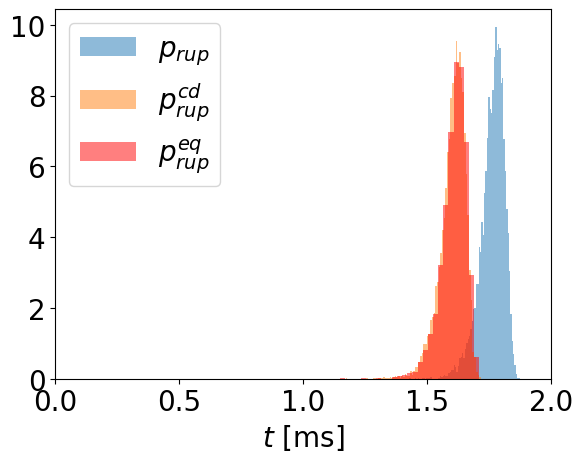

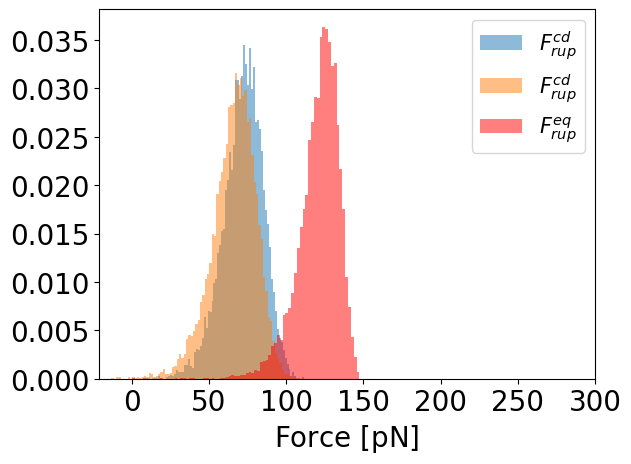

In [806]:


def fit_pt(F, t, r, t0, k0_est, initial_params):

    def likelihood(params, F):

        logk0,d = params
        beta = 1/4.1
        log_likelihood = 0

        log_likelihood += np.sum(logk0  + beta*F*d + np.exp(logk0)*(1-np.exp(beta*F*d))/(r*d))
        return -log_likelihood

    result = minimize(likelihood, initial_params, args=(F,),bounds = [(None,  None ),(None, None)], tol=1e-10)
    logk0,d = result.x
    print("Parameters:", np.exp(logk0),d, np.exp(logk0)/k0_est, logk0/np.log(k0_est))
    
    return  logk0,d

def fit_pt(t, r, t0, k0_est, initial_params):

    def likelihood(params, t):

        logk0,d = params
        beta = 1/4.1
        log_likelihood = 0
        F = r*(t-t0)
        log_likelihood += np.sum(logk0 + np.log(beta/r) + beta*F*d + np.exp(logk0)/(r*d)*(1-np.exp(beta*F*d)))
        return -log_likelihood

    result = minimize(likelihood, initial_params, args=(t,),bounds = [(None,  None ),(None, None)], tol=1e-10)
    logk0,d = result.x
    print("Parameters:", np.exp(logk0),d, np.exp(logk0)/k0_est, logk0/np.log(k0_est))
    
    return  logk0,d

# def plot_ptcd(k0, d,t):
#     r, t0 = rcdtab[0], 1.1
#     beta = 1/4.1
#     pt = k0*np.exp(beta*r*(t-t0)*d + k0/(beta*r*d)*(1-np.exp(beta*r*(t-t0)*d)))
#     plt.plot(t, pt)
#     return pt
# def plot_pt(k0, d,t):
#     r, t0 = rtab[0], .75
#     beta = 1/4.1
#     pt = k0*np.exp(beta*r*(t-t0)*d + k0/(beta*r*d)*(1-np.exp(beta*r*(t-t0)*d)))
#     plt.plot(t, pt)
#     return pt

# mini, maxi = 1, 2
# k0_est = 0.004008016032064128
initial_params  = [-20, .4 ]
logk0,d = fit_pt(trup[0], rtab[0], t0tab[0], k0, initial_params)
# plot_pt(np.exp(logk0), d,np.linspace(0.,2.,1000))
logk0,d = fit_pt(trupcd[0],250,1.05 , k0, initial_params)
# plot_ptcd(np.exp(logk0), d,np.linspace(0.,2.,1000))


# logk0,d = fit_pt(F[0], trup[0], rtab[0], t0tab[0], k0, initial_params)
# logk0,d = fit_pt(Fcd[0], trupcd[0], rcdtab[0], t0cdtab[0], k0, initial_params)


plt.hist(trup[0],80, alpha = .5, density = True, label=r'$p_{rup}$', linewidth=5)
plt.hist(trupcd[0],80, alpha = .5, density = True, label=r'$p^{cd}_{rup}$', linewidth=5)
plt.hist(trupeq[0],80, alpha = .5,color = 'r', density = True, label=r'$p^{eq}_{rup}$', linewidth=5)

# plt.yscale('log')
plt.xlim(0.,2.)
plt.xlabel(r'$t$ [ms]', fontsize=20)
# plt.ylabel('Distances [nm]', fontsize=20)

# Set custom tick positions
custom_ticks = np.arange(0.0, 2.1, 0.5)
# custom_ticksy = np.arange(0.0, 350, 50)
plt.xticks(custom_ticks)

# Set the font size of ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Show legend with fontsize 15
plt.legend(fontsize=20)
plt.savefig('fig2b.pdf', bbox_inches='tight')
plt.show()



plt.hist(F[0],80, alpha = .5, density = True, label=r'$F^{cd}_{rup}$', linewidth=5)
plt.hist(Fcd[0],80, alpha = .5, density = True, label=r'$F^{cd}_{rup}$', linewidth=5)
plt.hist(Frup_eq[0],80, alpha = .5,color = 'r', density = True, label=r'$F^{eq}_{rup}$', linewidth=5)
# plt.xlim(0.,2.)
plt.xlabel(r'$\mathrm{Force}$ [pN]', fontsize=20)
# plt.ylabel('Distances [nm]', fontsize=20)

# Set custom tick positions
custom_ticks = np.arange(0.0, 300.1, 50)
# custom_ticksy = np.arange(0.0, 350, 50)
plt.xticks(custom_ticks)

# Set the font size of ticks
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Show legend with fontsize 15
plt.legend(fontsize=15)
plt.show()


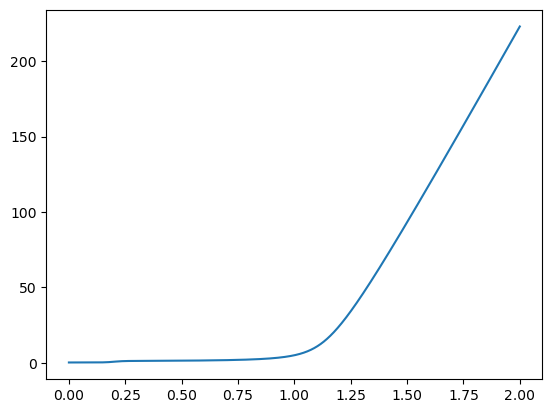

In [750]:
Feq = np.genfromtxt('Feq.csv', delimiter=',')[:,1]
plt.plot(np.linspace(0,2.,len(Feq)),Feq)

@jit(nopython=True)
def traj_trup_Feq(Feq, seed):
    np.random.seed(seed)

    dt = .0001
    t = 0.
#     xt, Fcantt, l, xeq, Fexpmol, Dx = np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1),np.zeros(steps-1)
    for i in range(len(Feq)):
        
        Fmol = Feq[i]
        kF = k0*np.exp(beta*Fmol*d) 
        if dt*kF > np.random.rand():
            trup = t
            Frup = Fmol
            break
            

        t += dt
 
    return trup, Frup

def get_trup_tab_Feq(Feq,num_trajs = 500):
    trup, F = np.zeros(num_trajs), np.zeros(num_trajs)
    for i in range(num_trajs):
    #     print(i)
        seed = np.random.choice(np.arange(1099000))
    #     print(seed)
        trup[i], F[i] = traj_trup_Feq(Feq, seed)
#         print(i,trup[i])
    return trup, F
trupeq, Frup_eq = [],[]
ti, Fi = get_trup_tab_Feq(Feq, num_trajs = 10**4)
trupeq.append(ti)
Frup_eq.append(Fi)



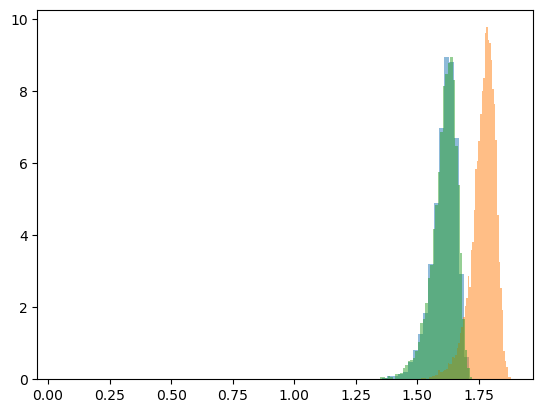

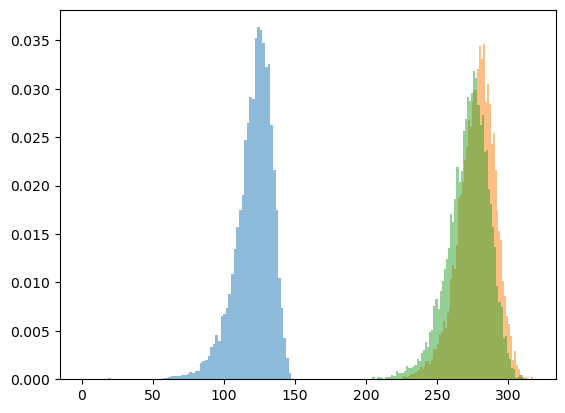

In [766]:
plt.hist(trupeq[0],80, alpha = .5, density = True)
plt.hist(trup[0],80, alpha = .5, density = True)
plt.hist(trupcd[0],80, alpha = .5, density = True)
plt.show()

plt.hist(Frup_eq[0],80, alpha = .5, density = True)
plt.hist(F[0],80, alpha = .5, density = True)
plt.hist(Fcd[0],80, alpha = .5, density = True)
plt.show()
# plt.hist(trupcd[0],80, alpha = .5, density = True)

In [688]:
trupeq

[array([1.4882, 1.7019, 1.6494, ..., 1.583 , 1.6238, 1.6728])]

In [537]:
kcant

10

/var/folders/q4/4wgv01t53ss2w3btpzzlgb6h0000gn/T/ipykernel_78009/3061411341.py:8: RuntimeWarning: overflow encountered in exp
  log_likelihood += np.sum(logk0 + beta*r*(t-t0)*d + np.exp(logk0)/(beta*r*d)*(1-np.exp(beta*r*(t-t0)*d)))
/var/folders/q4/4wgv01t53ss2w3btpzzlgb6h0000gn/T/ipykernel_78009/3061411341.py:8: RuntimeWarning: overflow encountered in multiply
  log_likelihood += np.sum(logk0 + beta*r*(t-t0)*d + np.exp(logk0)/(beta*r*d)*(1-np.exp(beta*r*(t-t0)*d)))
/var/folders/q4/4wgv01t53ss2w3btpzzlgb6h0000gn/T/ipykernel_78009/3061411341.py:8: RuntimeWarning: invalid value encountered in multiply
  log_likelihood += np.sum(logk0 + beta*r*(t-t0)*d + np.exp(logk0)/(beta*r*d)*(1-np.exp(beta*r*(t-t0)*d)))


3.184467000176565 2.7406177306678594


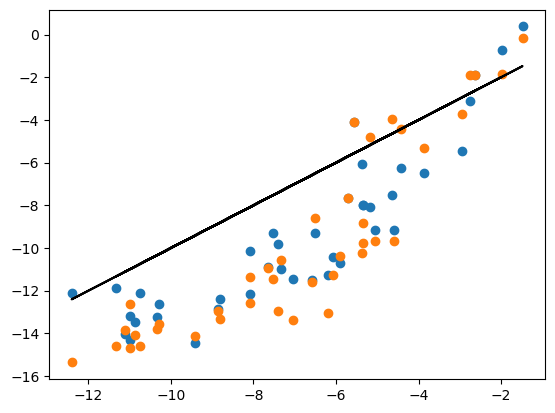

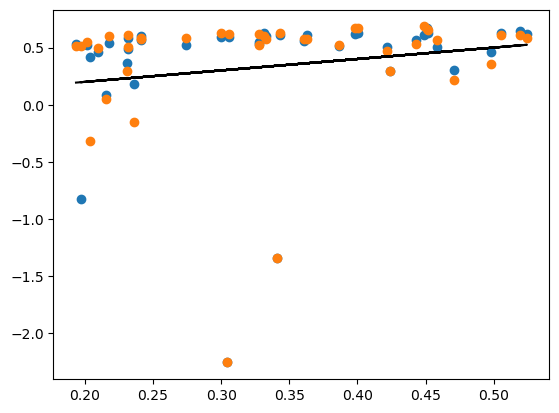

In [145]:
def fit_pt(t, r, t0, k0_est, initial_params):

    def likelihood(params, trup):
    # Compute the likelihood for the given parameters and samples
        logk0,d = params
        beta = 1/4.1
        log_likelihood = 0
        log_likelihood += np.sum(logk0 + beta*r*(t-t0)*d + np.exp(logk0)/(beta*r*d)*(1-np.exp(beta*r*(t-t0)*d)))
        return -log_likelihood

#     result = minimize(likelihood, initial_params, args=(trup,), tol=1e-10)
    result = minimize(likelihood, initial_params, args=(trup,),bounds = [(None, None),(None, None)], tol=1e-10)
    logk0,d = result.x
#     print( result.x)
#     print("Parameters:", np.exp(logk0),d, (np.exp(logk0))/k0_est)
    
    return  logk0,d


import os
import re
import numpy as np

# Directory containing the files
directory = 'data_cd0/'

# Regular expression pattern to extract 'a' and 'b' from file names
pattern = r'lnk0_([\d.]+)_([\d.]+)\.npy'
lnk0, lnk0cd_fit, lnk0_fit, dU, d, dcd_fit, d_fit = [], [], [], [], [], [], []
# Loop through files in the directory
for filename in os.listdir(directory):
    if filename.startswith('lnk0_') and filename.endswith('.npy'):
        # Extract 'a' and 'b' from the file name using regex
        match = re.match(pattern, filename)
        if match:
            a = float(match.group(1))
            b = float(match.group(2))
            dU.append(a)
            d.append(b/2)
#             print(f"File: {filename}, a: {a}, b: {b}")
            # Load the file and assign it to 'lnk0'
            lnk0.append(np.load(os.path.join(directory, filename)))
            trup = np.load('data_cd0/trup_' + str(a) + '_' + str(b)+'.npy')
            trupcd = np.load('data_cd0/trupcd_' + str(a) + '_' + str(b)+'.npy')
            r = np.load('data_cd0/r_' + str(a) + '_' + str(b)+'.npy')
            rcd = np.load('data_cd0/rcd_' + str(a) + '_' + str(b)+'.npy')
            t0 = np.load('data_cd0/t0_' + str(a) + '_' + str(b)+'.npy')
            t0cd = np.load('data_cd0/t0cd_' + str(a) + '_' + str(b)+'.npy')
#             d.append(b)
            
            initial_params = [lnk0[-1]+np.random.randn(),d[-1]+np.random.randn() ]
#             initial_params = [-10, .4]
            logk0cd_fiti,dcd_fiti = fit_pt(trupcd,  rcd, t0cd, np.exp(lnk0[-1]),initial_params)
            lnk0cd_fit.append(logk0cd_fiti)
            dcd_fit.append(dcd_fiti)
            
            logk0_fiti,d_fiti = fit_pt(trup,  r, t0, np.exp(lnk0[-1]),initial_params)
            lnk0_fit.append(logk0_fiti)
            d_fit.append(d_fiti)


lnk0cd_fit, lnk0_fit = np.asarray(lnk0cd_fit), np.asarray(lnk0_fit)
plt.plot(lnk0, lnk0cd_fit,'o')
plt.plot(lnk0, lnk0_fit,'o')
print(np.mean(abs(lnk0 - lnk0_fit)), np.mean(abs(lnk0 - lnk0cd_fit)))
# plt.plot(lnk0, .5*(lnk0cd_fit + lnk0_fit),'o')
plt.plot(lnk0, lnk0, 'k')
plt.show()
plt.plot(d, dcd_fit,'o')
plt.plot(d, d_fit,'o')
plt.plot(d, d, 'k')
plt.show()